## 抽平

In [1]:
import pandas as pd
import numpy as np

# 读取数据
data = pd.read_csv("../examples/merged_counts.tsv", sep="\t", index_col="Contig")
phatype = pd.read_csv("../examples/phatyp_prediction.tsv", sep="\t", index_col="Accession")

# 过滤低丰度病毒
filtered_data = data[(data > 500).sum(axis=1) >= 0.2 * data.shape[1]]

# 移除总reads数为零的样本（避免除以零错误）
# filtered_data = filtered_data.loc[:, filtered_data.sum() > 100]

# 计算所有样本的总reads数，并确定最小抽平深度
sample_sums = filtered_data.sum(axis=0)
min_depth = int(sample_sums.min())

# 定义抽平函数
def rarefy_column(col, depth):
    """对单个样本列进行抽平"""
    total = col.sum()
    if total == depth:
        return col
    else:
        # 生成多项式分布抽样结果
        rarefied = np.random.multinomial(depth, col / total)
        return pd.Series(rarefied, index=col.index)

# 设置随机种子保证可重复性
np.random.seed(42)

# 对每个样本进行抽平
rarefied_data = filtered_data.apply(
    rarefy_column,
    axis=0,
    args=(min_depth,)
)

# 将结果转换为DataFrame（保持格式一致）
rarefied_data = pd.DataFrame(
    rarefied_data,
    index=filtered_data.index,
    columns=filtered_data.columns
)

# 输出抽平后的数据
print(f"抽平深度: {min_depth}")

抽平深度: 9709600


Mann-Whitney U test:
Statistic: 539.0
p-value: 0.0189


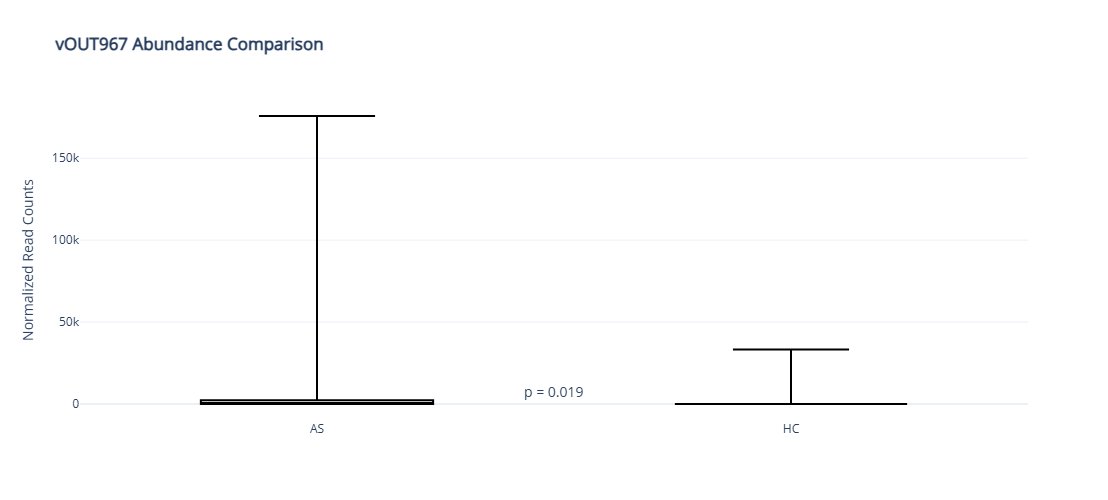

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# 提取目标contig数据
target_contig = 'vOUT967'
contig_data = rarefied_data.loc[target_contig].to_frame(name='Count')

# 添加分组信息
contig_data['Group'] = contig_data.index.map(
    lambda x: 'AS' if x.startswith('TXAS') else 'HC'
)

# 非参数检验（适用于非正态分布数据）
as_counts = contig_data[contig_data.Group == 'AS']['Count']
hc_counts = contig_data[contig_data.Group == 'HC']['Count']
stat, p_value = mannwhitneyu(as_counts, hc_counts, alternative='greater')

print(f"Mann-Whitney U test:\n"
      f"Statistic: {stat}\n"
      f"p-value: {p_value:.4f}")
import plotly.graph_objects as go

# 生成受控抖动
np.random.seed(42)
jitter_as = np.random.uniform(-0.1, 0.1, len(as_counts))
jitter_hc = np.random.uniform(-0.1, 0.1, len(hc_counts))

fig = go.Figure()

# 添加箱线图
fig.add_trace(go.Box(
    x=contig_data['Group'],
    y=contig_data['Count'],
    boxpoints=False,
    line_color='black',
    fillcolor='rgba(0,0,0,0)'
))



# 添加统计标注
fig.add_annotation(
    x=0.5,
    y=max_count*1.2,
    text=f'p = {p_value:.2e}' if p_value < 0.001 else f'p = {p_value:.3f}',
    showarrow=False,
    font=dict(size=14)
)

fig.update_layout(
    title=f'<b>{target_contig} Abundance Comparison</b>',
    yaxis_title='Normalized Read Counts',
    template='plotly_white',
    height=500,
    width=700
)

fig.show()

## alpha_diversity

In [30]:
# 定义多样性计算函数
def alpha_diversity(rarefied_df):
    def _observed_otus(col):
        return (col > 0).sum()
    
    def _shannon(col):
        p = col[col > 0] / col.sum()
        return -sum(p * np.log(p)) if p.any() else 0
    
    def _simpson(col):
        p = col[col > 0] / col.sum()
        return 1 - sum(p**2) if p.any() else 0
    
    return pd.DataFrame({
        'Observed_OTUs': rarefied_df.apply(_observed_otus),
        'Shannon': rarefied_df.apply(_shannon),
        'Simpson': rarefied_df.apply(_simpson)
    })

# 计算每个样本的α多样性
alpha_df = alpha_diversity(rarefied_data)  # 转置为样本在行

In [32]:
# 添加分组信息
alpha_df['Group'] = alpha_df.index.map(
    lambda x: 'AS' if x.startswith('TXAS') else 'HC'
)

# 数据重组用于绘图
plot_df = alpha_df.reset_index().melt(
    id_vars=['index', 'Group'],
    value_vars=['Observed_OTUs', 'Shannon', 'Simpson'],
    var_name='Metric',
    value_name='Value'
)

In [34]:
from scipy.stats import mannwhitneyu

# 自动执行组间比较
results = {}
for metric in ['Observed_OTUs', 'Shannon', 'Simpson']:
    as_data = alpha_df[alpha_df.Group == 'AS'][metric]
    hc_data = alpha_df[alpha_df.Group == 'HC'][metric]
    stat, p = mannwhitneyu(as_data, hc_data, alternative='two-sided')
    results[metric] = {
        'statistic': stat,
        'p_value': p,
        'AS_mean': as_data.mean(),
        'HC_mean': hc_data.mean()
    }

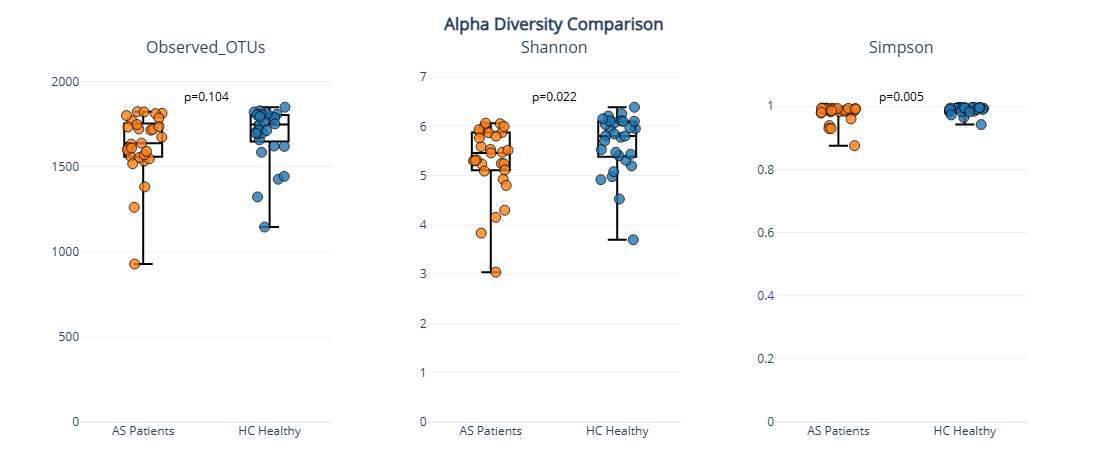

In [41]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import mannwhitneyu
import numpy as np

def plot_alpha_comparison(alpha_df, metrics):
    # 创建多子图
    fig = make_subplots(
        rows=1, 
        cols=len(metrics), 
        subplot_titles=metrics,
        horizontal_spacing=0.1
    )
    
    # 统一视觉参数
    VISUAL_CONFIG = {
        'jitter_range': 0.15,  # 缩小抖动范围
        'marker_size': 10,
        'box_width': 0.3,
        'y_expand': 1.15,
        'colors': {'AS': '#FF7F0E', 'HC': '#1F77B4'}  # 添加颜色配置
    }
    
    for col_idx, metric in enumerate(metrics, 1):
        # 提取当前指标数据
        sub_df = alpha_df[['Group', metric]].copy()
        sub_df.columns = ['Group', 'Value']
        
        # 统计检验
        as_data = sub_df[sub_df.Group=='AS']['Value']
        hc_data = sub_df[sub_df.Group=='HC']['Value']
        _, p_value = mannwhitneyu(as_data, hc_data)
        
        # 坐标定位
        group_pos = {'AS': 0, 'HC': 1}
        y_max = sub_df['Value'].max() * VISUAL_CONFIG['y_expand']
        
        # 绘制抖动点（关键修正点：去除多余的列表包装）
        for group in ['AS', 'HC']:
            group_data = sub_df[sub_df.Group == group]
            if len(group_data) > 0:  # 添加空值保护
                jitter = np.random.uniform(
                    -VISUAL_CONFIG['jitter_range'],
                    VISUAL_CONFIG['jitter_range'],
                    len(group_data)
                )
                fig.add_trace(go.Scatter(
                    x=group_pos[group] + jitter,  # 直接使用数组，不加列表包装
                    y=group_data['Value'],
                    mode='markers',
                    marker=dict(
                        color=VISUAL_CONFIG['colors'][group],
                        size=VISUAL_CONFIG['marker_size'],
                        opacity=0.8,
                        line=dict(width=1, color='black')
                    ),
                    showlegend=False
                ), row=1, col=col_idx)
            
        # 添加箱线图
        fig.add_trace(go.Box(
            x=sub_df['Group'].map(group_pos),
            y=sub_df['Value'],
            boxpoints=False,
            line=dict(color='black', width=2),
            fillcolor='rgba(0,0,0,0)',  # 完全透明填充
            width=VISUAL_CONFIG['box_width'],
            showlegend=False
        ), row=1, col=col_idx)
        
        # 显著性标注
        fig.add_annotation(
            xref=f'x{col_idx}',
            yref=f'y{col_idx}',
            x=0.5,
            y=y_max * 0.9,
            text=f'p={p_value:.2e}' if p_value < 0.001 else f'p={p_value:.3f}',
            showarrow=False,
            font=dict(size=12, color='black'),
            bgcolor='white'
        )
        
        # 设置坐标轴
        fig.update_layout({
            f'xaxis{col_idx}': {
                'tickvals': [0, 1],
                'ticktext': ['AS Patients', 'HC Healthy'],
                'range': [-0.5, 1.5],
                'showgrid': False
            },
            f'yaxis{col_idx}': {
                'range': [0, y_max],
                'gridcolor': '#F0F0F0'
            }
        })
    
    # 全局布局
    fig.update_layout(
        template="plotly_white",
        height=450,
        width=1000,
        margin=dict(t=60, b=20),
        title_text="<b>Alpha Diversity Comparison</b>",
        title_x=0.5
    )
    return fig

# 使用示例
metrics = ['Observed_OTUs', 'Shannon', 'Simpson']
fig = plot_alpha_comparison(alpha_df, metrics)
fig.show()

## $\beta$ 多样性分析

In [54]:
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
import numpy as np

# 数据标准化（相对丰度转换）
normalized_data = rarefied_data.div(rarefied_data.sum(axis=0), axis=1)

# 转置为样本×特征格式
sample_by_otu = normalized_data.T

# 计算Bray-Curtis距离矩阵
bc_dm = beta_diversity(
    metric='braycurtis',
    counts=sample_by_otu.values,
    ids=sample_by_otu.index
)

# 转换为DataFrame格式
dm_df = pd.DataFrame(
    bc_dm.data,
    index=sample_by_otu.index,
    columns=sample_by_otu.index
)
sample_by_otu['Group'] = sample_by_otu.index.map(
    lambda x: 'AS' if x.startswith('TXAS') else 'HC'
)

In [57]:
# 执行PCoA
pcoa_results = pcoa(bc_dm)

# 提取主坐标
pcoa_df = pd.DataFrame(
    pcoa_results.samples.values,
    index=sample_by_otu.index,
    columns=[f"PC{i+1}" for i in range(pcoa_results.samples.shape[1])]
)

# 合并分组信息
pcoa_df = pcoa_df.join(sample_by_otu[['Group']])

D:\app_download_rj\Conda\Lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:214: RuntimeWarning:

The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.03539880394355806 whereas the largest positive one is 2.200547885539804.



In [58]:
from skbio.stats.distance import permanova

# 准备分组信息
groups = pcoa_df['Group'].values

# 执行PERMANOVA检验
permanova_result = permanova(
    distance_matrix=bc_dm,
    grouping=groups,
    permutations=999
)

print(f"PERMANOVA结果：\n"
      f"F-value: {permanova_result['test statistic']:.3f}\n"
      f"p-value: {permanova_result['p-value']:.4f}\n"
      f"解释度: {permanova_result['test statistic']/(permanova_result['test statistic']+1):.1%}")

PERMANOVA结果：
F-value: 1.059
p-value: 0.3460
解释度: 51.4%


C:\Users\Jun Rao\AppData\Local\Temp\ipykernel_2820\957288408.py:46: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Jun Rao\AppData\Local\Temp\ipykernel_2820\957288408.py:47: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Jun Rao\AppData\Local\Temp\ipykernel_2820\957288408.py:48: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



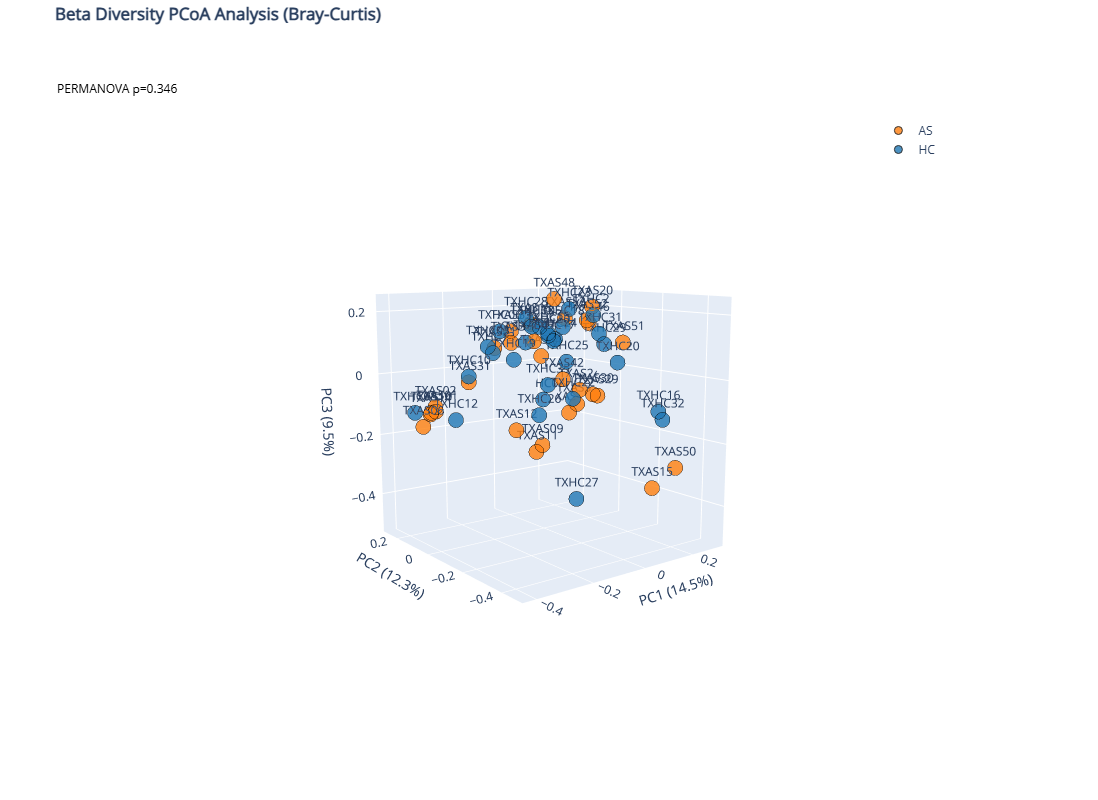

In [59]:
import plotly.graph_objects as go

# 配置颜色方案
COLOR_MAP = {
    'AS': '#FF7F0E',
    'HC': '#1F77B4'
}

# 创建3D散点图
fig = go.Figure()

for group in ['AS', 'HC']:
    group_df = pcoa_df[pcoa_df.Group == group]
    fig.add_trace(go.Scatter3d(
        x=group_df.PC1,
        y=group_df.PC2,
        z=group_df.PC3,
        mode='markers+text',
        marker=dict(
            size=8,
            color=COLOR_MAP[group],
            opacity=0.8,
            line=dict(color='black', width=1)
        ),
        text=group_df.index,
        textposition='top center',
        name=group
    ))

# 添加统计标注
fig.add_annotation(
    x=0.05,
    y=0.95,
    xref="paper",
    yref="paper",
    text=f"PERMANOVA p={permanova_result['p-value']:.3f}",
    showarrow=False,
    font=dict(size=12, color='black'),
    bgcolor='white'
)

# 设置布局
fig.update_layout(
    title="<b>Beta Diversity PCoA Analysis (Bray-Curtis)</b>",
    scene=dict(
        xaxis_title=f'PC1 ({pcoa_results.proportion_explained[0]:.1%})',
        yaxis_title=f'PC2 ({pcoa_results.proportion_explained[1]:.1%})',
        zaxis_title=f'PC3 ({pcoa_results.proportion_explained[2]:.1%})',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=0.5)
        )
    ),
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0.8,
        y=0.9,
        bgcolor='rgba(255,255,255,0.9)'
    )
)

fig.show()

C:\Users\Jun Rao\AppData\Local\Temp\ipykernel_2820\1750979390.py:25: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Jun Rao\AppData\Local\Temp\ipykernel_2820\1750979390.py:26: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Jun Rao\AppData\Local\Temp\ipykernel_2820\1750979390.py:25: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Jun Rao\AppData\Local\Temp\ipykernel_2820\1750979390.py:26: FutureWarning:

Series

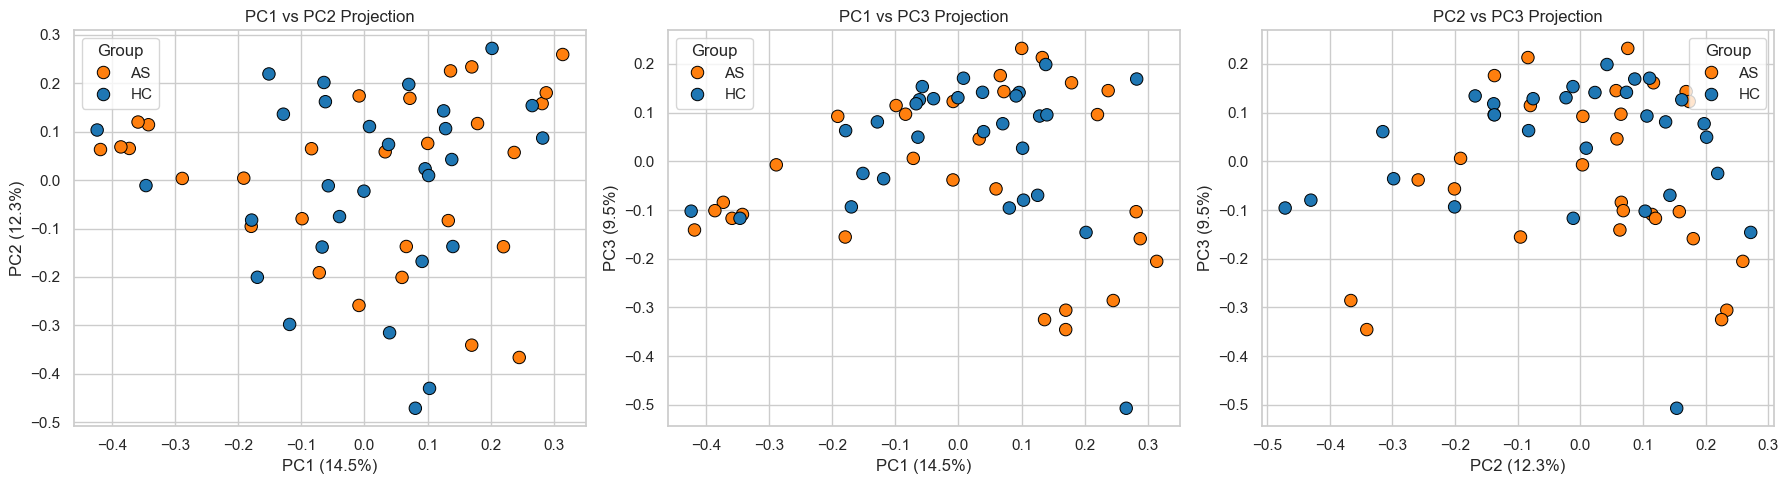

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置样式
sns.set(style="whitegrid", palette="pastel")

# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 绘制三个主成分组合
combinations = [(0,1), (0,2), (1,2)]
titles = ['PC1 vs PC2', 'PC1 vs PC3', 'PC2 vs PC3']

for ax, (x, y), title in zip(axes, combinations, titles):
    sns.scatterplot(
        x=pcoa_df[f'PC{x+1}'],
        y=pcoa_df[f'PC{y+1}'],
        hue=pcoa_df['Group'],
        palette=COLOR_MAP,
        s=80,
        edgecolor='black',
        ax=ax
    )
    ax.set_title(f"{title} Projection")
    ax.set_xlabel(f'PC{x+1} ({pcoa_results.proportion_explained[x]:.1%})')
    ax.set_ylabel(f'PC{y+1} ({pcoa_results.proportion_explained[y]:.1%})')
    ax.legend(title='Group')

plt.tight_layout()
plt.show()

## 噬菌体活性

In [64]:
# 从phatype表中提取virulent标记（1表示virulent，其他情况为0）
virulent_mask = phatype['TYPE'].apply(lambda x: 1 if x == 'virulent' else 0)

# 对齐索引并填充缺失值为0（处理不存在于phatype中的Contig）
virulent_mask = virulent_mask.reindex(rarefied_data.index, fill_value=0)

# 将抽平数据与virulent标记相乘（保留virulent的计数，其他变为0）
virulent_counts = rarefied_data.multiply(virulent_mask, axis=0).sum(axis=0)

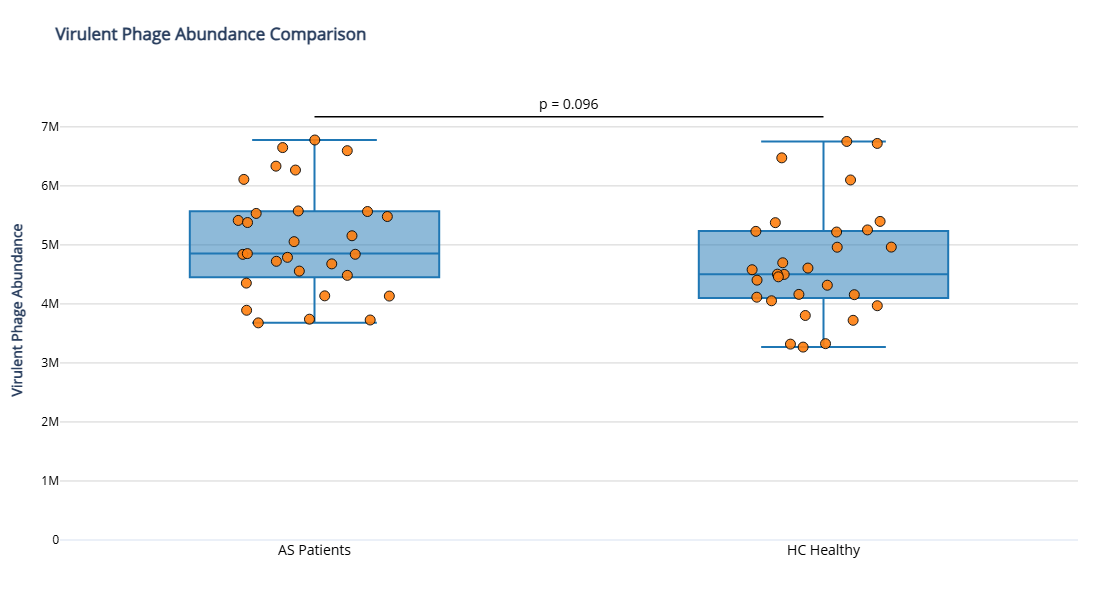

In [65]:
import plotly.graph_objects as go
from scipy.stats import mannwhitneyu
import pandas as pd
import numpy as np

# 准备数据
df = virulent_counts.reset_index(name='Count')
df['Group'] = df['index'].apply(lambda x: 'AS' if x.startswith('TXAS') else 'HC')

# 计算统计量
as_counts = df[df['Group'] == 'AS']['Count']
hc_counts = df[df['Group'] == 'HC']['Count']
stat, p_value = mannwhitneyu(as_counts, hc_counts, alternative='two-sided')

# 创建基础图形
fig = go.Figure()

# 先绘制散点（确保在底层）
group_positions = {'AS': 0, 'HC': 1}  # 定义组别坐标位置
for group in ['AS', 'HC']:
    group_data = df[df['Group'] == group]
    # 生成可控抖动（限制在±0.15范围内）
    jitter = np.random.uniform(low=-0.15, high=0.15, size=len(group_data))
    fig.add_trace(go.Scatter(
        x=[group_positions[group] + j for j in jitter],  # 中心位置+抖动
        y=group_data['Count'],
        mode='markers',
        marker=dict(
            color='rgb(255, 127, 14)',  # 醒目橙色
            size=10,
            opacity=0.9,
            line=dict(width=1, color='black')
        ),
        name=group,
        showlegend=False
    ))

# 再绘制箱线图（覆盖在散点之上）
for group in ['AS', 'HC']:
    group_data = df[df['Group'] == group]
    fig.add_trace(go.Box(
        x=[group_positions[group]] * len(group_data),
        y=group_data['Count'],
        name=group,
        boxpoints=False,  # 不显示原始点
        marker_color='rgb(31, 119, 180)',  # 标准蓝色
        line_width=2,
        showlegend=False
    ))

# 计算合理的y轴范围
y_max = df['Count'].max() * 1.15

# 添加显著性标记
fig.add_shape(type="line",
    x0=0, x1=1, y0=y_max*0.92, y1=y_max*0.92,
    line=dict(color="black", width=1.5)
)
fig.add_annotation(
    x=0.5, y=y_max*0.95,
    text=f'p = {p_value:.2e}' if p_value < 0.001 else f'p = {p_value:.3f}',
    showarrow=False,
    font=dict(size=14, color='black')
)

# 设置布局
fig.update_layout(
    title="<b>Virulent Phage Abundance Comparison</b>",
    xaxis_title="",
    yaxis_title="<b>Virulent Phage Abundance</b>",
    template="plotly_white",
    margin=dict(l=60, r=30, t=80, b=60),
    width=800,
    height=600,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['AS Patients', 'HC Healthy'],
        tickfont=dict(size=14, color='black'),
        range=[-0.5, 1.5]  # 限制x轴范围
    ),
    yaxis=dict(
        range=[0, y_max],
        tickfont=dict(size=12, color='black'),
        gridcolor='lightgrey'
    ),
    plot_bgcolor='white'
)

# 显示图形
fig.show()